<a href="https://colab.research.google.com/github/rondinell/Intelig-ncia-Artificial/blob/main/lstm_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 0. Instalando e importando bibliotecas ---
✓ Bibliotecas importadas com sucesso.

--- 1. Baixando e preparando os dados ---
Calculando indicadores de tendência de longo prazo...
✓ 1331 registros preparados para os modelos.

--- 2. Treinando o Modelo de Detecção de Anomalias (Autoencoder) ---
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
✓ Modelo de anomalia treinado. Limiar: 0.0000. Anomalias: 27 dias.

--- 3. Treinando o Modelo de Previsão de Direção (LSTM) ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✓ Modelo LSTM treinado.

--- 4. Combinando as Previsões e Gerando Sinais Finais ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step

--- Análise dos Sinais Combinados (Últimos 60 dias do teste) ---
            Close_BBAS3.SA  Realmente_Subiu_2%_5dias  LSTM_Prob_Subir  \
Date                                                                    
2025-04-24       27.302280                         1         0.085272   
2025-04-25       27.607828                         1         0.084841   
2025-04-28       27.942947                         0         0.086018   
2025-04-29       28.090792                         1         0.088296   
2025-04-30       28.514618                         0         0.090981   
2025-05-02       28.485048                         1         0.093970   
2025-05-05       28.701891                         0         0.096428   
2025-05-06       28.485048                         1         0.099102   
2025-05-07       28.889162                         0         0.100826   
2025-05-

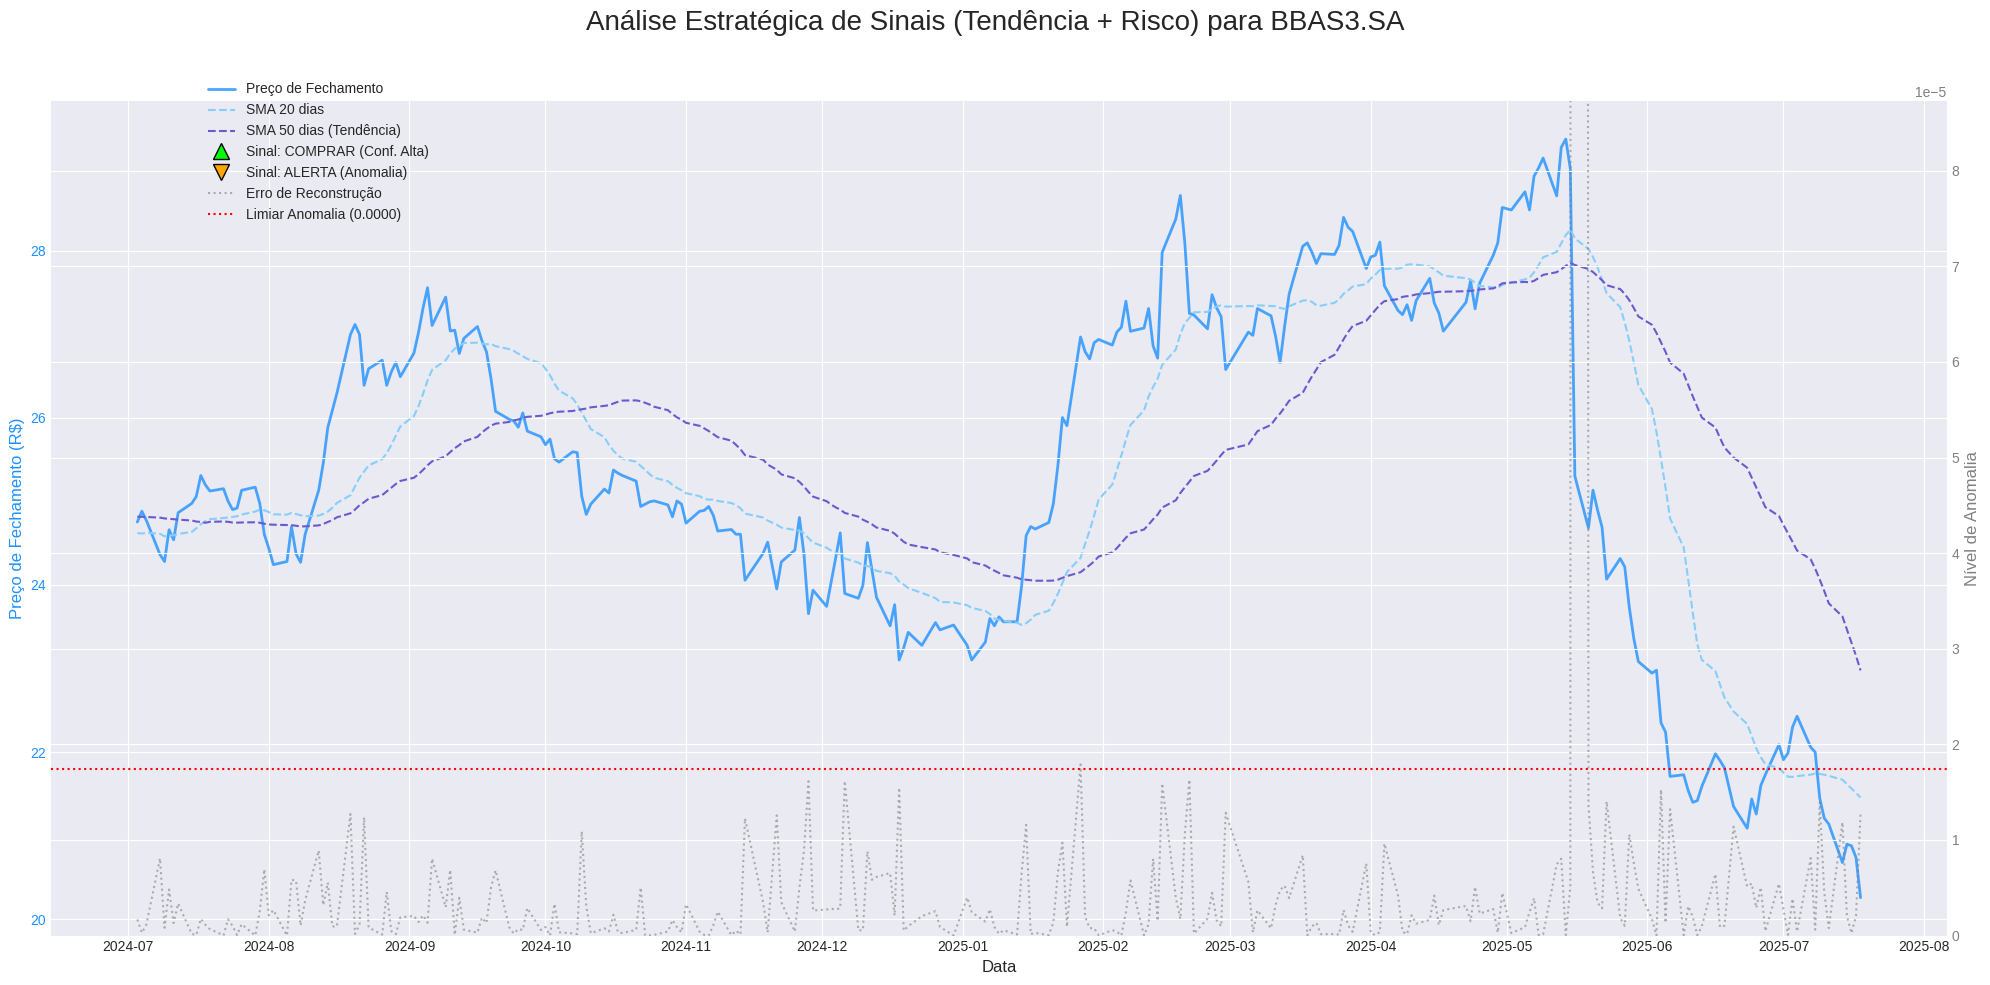

In [ ]:
# ===================================================================================
# IA NOS INVESTIMENTOS: ESTUDO DE CASO AVANÇADO (VERSÃO MELHORADA)
# Combinando uma LSTM (Estrategista) com um Autoencoder (Analista de Risco)
# ESTRATÉGIA: OPERAR A FAVOR DA TENDÊNCIA
# Autor: Rondinelli Alves de Andrade, com assistência de IA
# ===================================================================================

# --- Passo 0: Instalação e Importação das Bibliotecas ---
print("--- 0. Instalando e importando bibliotecas ---")
# Se estiver no Google Colab, a 'ta' pode precisar de instalação
!pip install ta yfinance --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from datetime import datetime
import ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
print("✓ Bibliotecas importadas com sucesso.")

# Configurações para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)


# ============================================================
# 1. OBTER E PREPARAR OS DADOS
# ============================================================
print("\n--- 1. Baixando e preparando os dados ---")
TICKER = 'BBAS3.SA'
df = yf.download(TICKER, start="2020-01-01", end=datetime.now().strftime("%Y-%m-%d"), progress=False, auto_adjust=True)
if df.empty:
    raise ValueError(f"Nenhum dado retornado para o ticker {TICKER}.")

# Flatten the MultiIndex by joining the levels
df.columns = ['_'.join(col).strip() for col in df.columns.values]

# Define the new column names
CLOSE_COL = f'Close_{TICKER}'
OPEN_COL = f'Open_{TICKER}'
HIGH_COL = f'High_{TICKER}'
LOW_COL = f'Low_{TICKER}'
VOLUME_COL = f'Volume_{TICKER}'


# --- MODIFICADO: Alvo mais robusto e indicadores de tendência ---
# Acessar corretamente os precios de fechamento
close_prices = df[CLOSE_COL]

# Indicadores Técnicos estándar
df['SMA_14'] = ta.trend.sma_indicator(close_prices.squeeze(), window=14)
df['RSI'] = ta.momentum.rsi(close_prices.squeeze(), window=14)
macd = ta.trend.MACD(close_prices.squeeze())
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# --- NOVO: Indicadores de Tendência (curto e longo prazo) ---
# Usaremos para filtrar os sinais de compra
print("Calculando indicadores de tendência de longo prazo...")
df['SMA_20'] = ta.trend.sma_indicator(close_prices.squeeze(), window=20)
df['SMA_50'] = ta.trend.sma_indicator(close_prices.squeeze(), window=50)

# --- NOVO: Alvo da LSTM mais inteligente e realista ---
# O objetivo não é prever o dia seguinte, mas sim um movimento relevante.
# Alvo = 1 si o preço subir pelo menos 2% em 5 dias.
HORIZONTE = 5
AUMENTO_MINIMO = 0.02 # 2%
# Acessar corretamente os precios de fechamento para o cálculo do alvo
df['Future_Close'] = df[CLOSE_COL].shift(-HORIZONTE)
df['Target'] = (df['Future_Close'] > df[CLOSE_COL] * (1 + AUMENTO_MINIMO)).astype(int)


# Retornos Diários para o Autoencoder - Acessar corretamente o precio de fechamento
df['Return'] = df[CLOSE_COL].pct_change()

# Limpar datos (remover linhas com NaN gerados pelos indicadores)
df.dropna(inplace=True)
print(f"✓ {len(df)} registros preparados para os modelos.")


# ===================================================================================
# 2. MODELO 1: AUTOENCODER PARA DETECÇÃO DE ANOMALIAS (O Analista de Risco)
# (Nenhuma mudança necessária nesta seção)
# ===================================================================================
print("\n--- 2. Treinando o Modelo de Detecção de Anomalias (Autoencoder) ---")

returns_data = df[['Return']].values
scaler_ae = MinMaxScaler(feature_range=(0, 1))
scaled_returns = scaler_ae.fit_transform(returns_data)

input_dim = scaled_returns.shape[1]
encoding_dim = 1
input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation="relu")(input_layer)
encoder = Dense(4, activation="relu")(encoder)
encoder_output = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(4, activation="relu")(encoder_output)
decoder = Dense(8, activation="relu")(decoder)
decoder_output = Dense(input_dim, activation="sigmoid")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder_output)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(scaled_returns, scaled_returns, epochs=50, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)

reconstructions = autoencoder.predict(scaled_returns)
reconstruction_error = np.mean(np.square(scaled_returns - reconstructions), axis=1)
df['Reconstruction_Error'] = reconstruction_error

anomaly_threshold = np.percentile(reconstruction_error, 98)
df['Is_Anomaly'] = (df['Reconstruction_Error'] > anomaly_threshold).astype(int)
print(f"✓ Modelo de anomalia treinado. Limiar: {anomaly_threshold:.4f}. Anomalias: {df['Is_Anomaly'].sum()} dias.")


# ===================================================================================
# 3. MODELO 2: LSTM PARA PREVISÃO DE DIREÇÃO (O Estrategista)
# ===================================================================================
print("\n--- 3. Treinando o Modelo de Previsão de Direção (LSTM) ---")

# --- MODIFICADO: LSTM agora aprende com os indicadores de tendência ---
features_list = [OPEN_COL, HIGH_COL, LOW_COL, CLOSE_COL, VOLUME_COL,
                 'SMA_14', 'RSI', 'MACD', 'MACD_Signal',
                 'SMA_20', 'SMA_50'] # <-- Adicionamos os novos indicadores
# Acessar correctamente as features
features = df[features_list].values
target = df['Target'].values

scaler_lstm = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_lstm.fit_transform(features)

SEQ_LENGTH = 30
X, y = [], []
for i in range(SEQ_LENGTH, len(scaled_features)):
    X.append(scaled_features[i-SEQ_LENGTH:i, :])
    y.append(target[i])
X, y = np.array(X), np.array(y)

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model_lstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
print("✓ Modelo LSTM treinado.")


# ===================================================================================
# 4. A MÁGICA: COMBINANDO OS DOIS MODELOS E GERANDO SINAIS
# ===================================================================================
print("\n--- 4. Combinando as Previsões e Gerando Sinais Finais ---")

predictions_proba = model_lstm.predict(X_test).flatten()
lstm_signals = (predictions_proba > 0.3).astype(int)

df_test = df.iloc[-len(X_test):].copy()
df_test['LSTM_Signal'] = lstm_signals
df_test['LSTM_Prob_Subir'] = predictions_proba

# --- LÓGICA DE DECISÃO TOTALMENTE MODIFICADA ---
df_test['Sinal_Final'] = 'MANTER'

# Condição 1: A tendência principal é de alta? (Média curta acima da longa)
is_uptrend = df_test['SMA_20'] > df_test['SMA_50']

# Condição 2: A LSTM prevê uma alta?
lstm_predicts_up = df_test['LSTM_Signal'] == 1

# Condição 3: O mercado está estável (sem anomalias)?
market_is_stable = df_test['Is_Anomaly'] == 0

# A condição final de COMPRA agora exige que todas as três condições sejam verdadeiras
buy_condition = is_uptrend & lstm_predicts_up & market_is_stable
df_test.loc[buy_condition, 'Sinal_Final'] = 'COMPRAR (Conf. Alta)'

# A condição de ALERTA permanece a mesma: LSTM otimista, mas mercado anômalo
anomaly_alert_condition = lstm_predicts_up & (df_test['Is_Anomaly'] == 1)
df_test.loc[anomaly_alert_condition, 'Sinal_Final'] = 'ALERTA (Anomalia)'

# Mostrar os resultados
print("\n--- Análise dos Sinais Combinados (Últimos 60 dias do teste) ---")
final_results = df_test[[CLOSE_COL, 'Target', 'LSTM_Prob_Subir', 'Is_Anomaly', 'Sinal_Final']].tail(60)
final_results.rename(columns={'Target': 'Realmente_Subiu_2%_5dias'}, inplace=True)
print(final_results)

# Avaliar a acurácia do sinal de "COMPRAR (Conf. Alta)"
sinais_compra_confiaveis = final_results[final_results['Sinal_Final'] == 'COMPRAR (Conf. Alta)']
if not sinais_compra_confiaveis.empty:
    acuracia_compra = accuracy_score(sinais_compra_confiaveis['Realmente_Subiu_2%_5dias'], np.ones(len(sinais_compra_confiaveis)))
    print(f"\n- Dos {len(sinais_compra_confiaveis)} sinais 'COMPRAR (Conf. Alta)' gerados, a acuracia (acertou que subiu >2% em 5d) foi de: {acuracia_compra:.2%}")
else:
    print("\n- Nenhum sinal de 'COMPRAR (Conf. Alta)' foi gerado no período analisado.")


# ===================================================================================
# 5. VISUALIZAÇÃO GRÁFICA DOS RESULTADOS
# ===================================================================================
print("\n--- 5. Gerando gráfico final ---")
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax1 = plt.subplots(figsize=(20, 10))

# Gráfico de Preço e Médias Móveis
ax1.plot(df_test.index, df_test[CLOSE_COL], label='Preço de Fechamento', color='dodgerblue', linewidth=2, alpha=0.8)
ax1.plot(df_test.index, df_test['SMA_20'], label='SMA 20 dias', color='lightskyblue', linestyle='--', linewidth=1.5)
ax1.plot(df_test.index, df_test['SMA_50'], label='SMA 50 dias (Tendência)', color='slateblue', linestyle='--', linewidth=1.5)

ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Preço de Fechamento (R$)', color='dodgerblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='dodgerblue')

# Marcar Sinais de Compra (agora mais raros e precisos)
buy_signals_dates = df_test[df_test['Sinal_Final'] == 'COMPRAR (Conf. Alta)'].index
ax1.plot(buy_signals_dates, df_test.loc[buy_signals_dates, CLOSE_COL], '^', markersize=12, color='lime', markeredgecolor='black', label='Sinal: COMPRAR (Conf. Alta)')

# Marcar Alertas de Anomalia
anomaly_alerts_dates = df_test[df_test['Sinal_Final'] == 'ALERTA (Anomalia)'].index
ax1.plot(anomaly_alerts_dates, df_test.loc[anomaly_alerts_dates, CLOSE_COL], 'v', markersize=12, color='orange', markeredgecolor='black', label='Sinal: ALERTA (Anomalia)')

# Eixo secundário para o Erro de Reconstrução
ax2 = ax1.twinx()
ax2.plot(df_test.index, df_test['Reconstruction_Error'], color='gray', linestyle=':', alpha=0.6, label='Erro de Reconstrução')
ax2.axhline(y=anomaly_threshold, color='red', linestyle=':', label=f'Limiar Anomalia ({anomaly_threshold:.4f})')
ax2.set_ylabel('Nível de Anomalia', color='gray', fontsize=12)
ax2.tick_params(axis='y', labelcolor='gray')
ax2.set_ylim(0, anomaly_threshold * 5)

# Título e Legendas
fig.suptitle(f'Análise Estratégica de Sinais (Tendência + Risco) para {TICKER}', fontsize=20)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.92), fontsize=10)

# Formatação do eixo X
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=20))
plt.xticks(rotation=45)
fig.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta layout para não cortar o título
plt.show()